In [ ]:
import numpy 
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from torch import nn
from torch.nn import functional as F
import math

import Vae_AttentionBlock, Vae_ResidualBlock
import torch
from torch import nn
from torch.nn import functional as F
import math
import Vae_AttentionBlock
import SelfAttention

ModuleNotFoundError: No module named 'decoder'

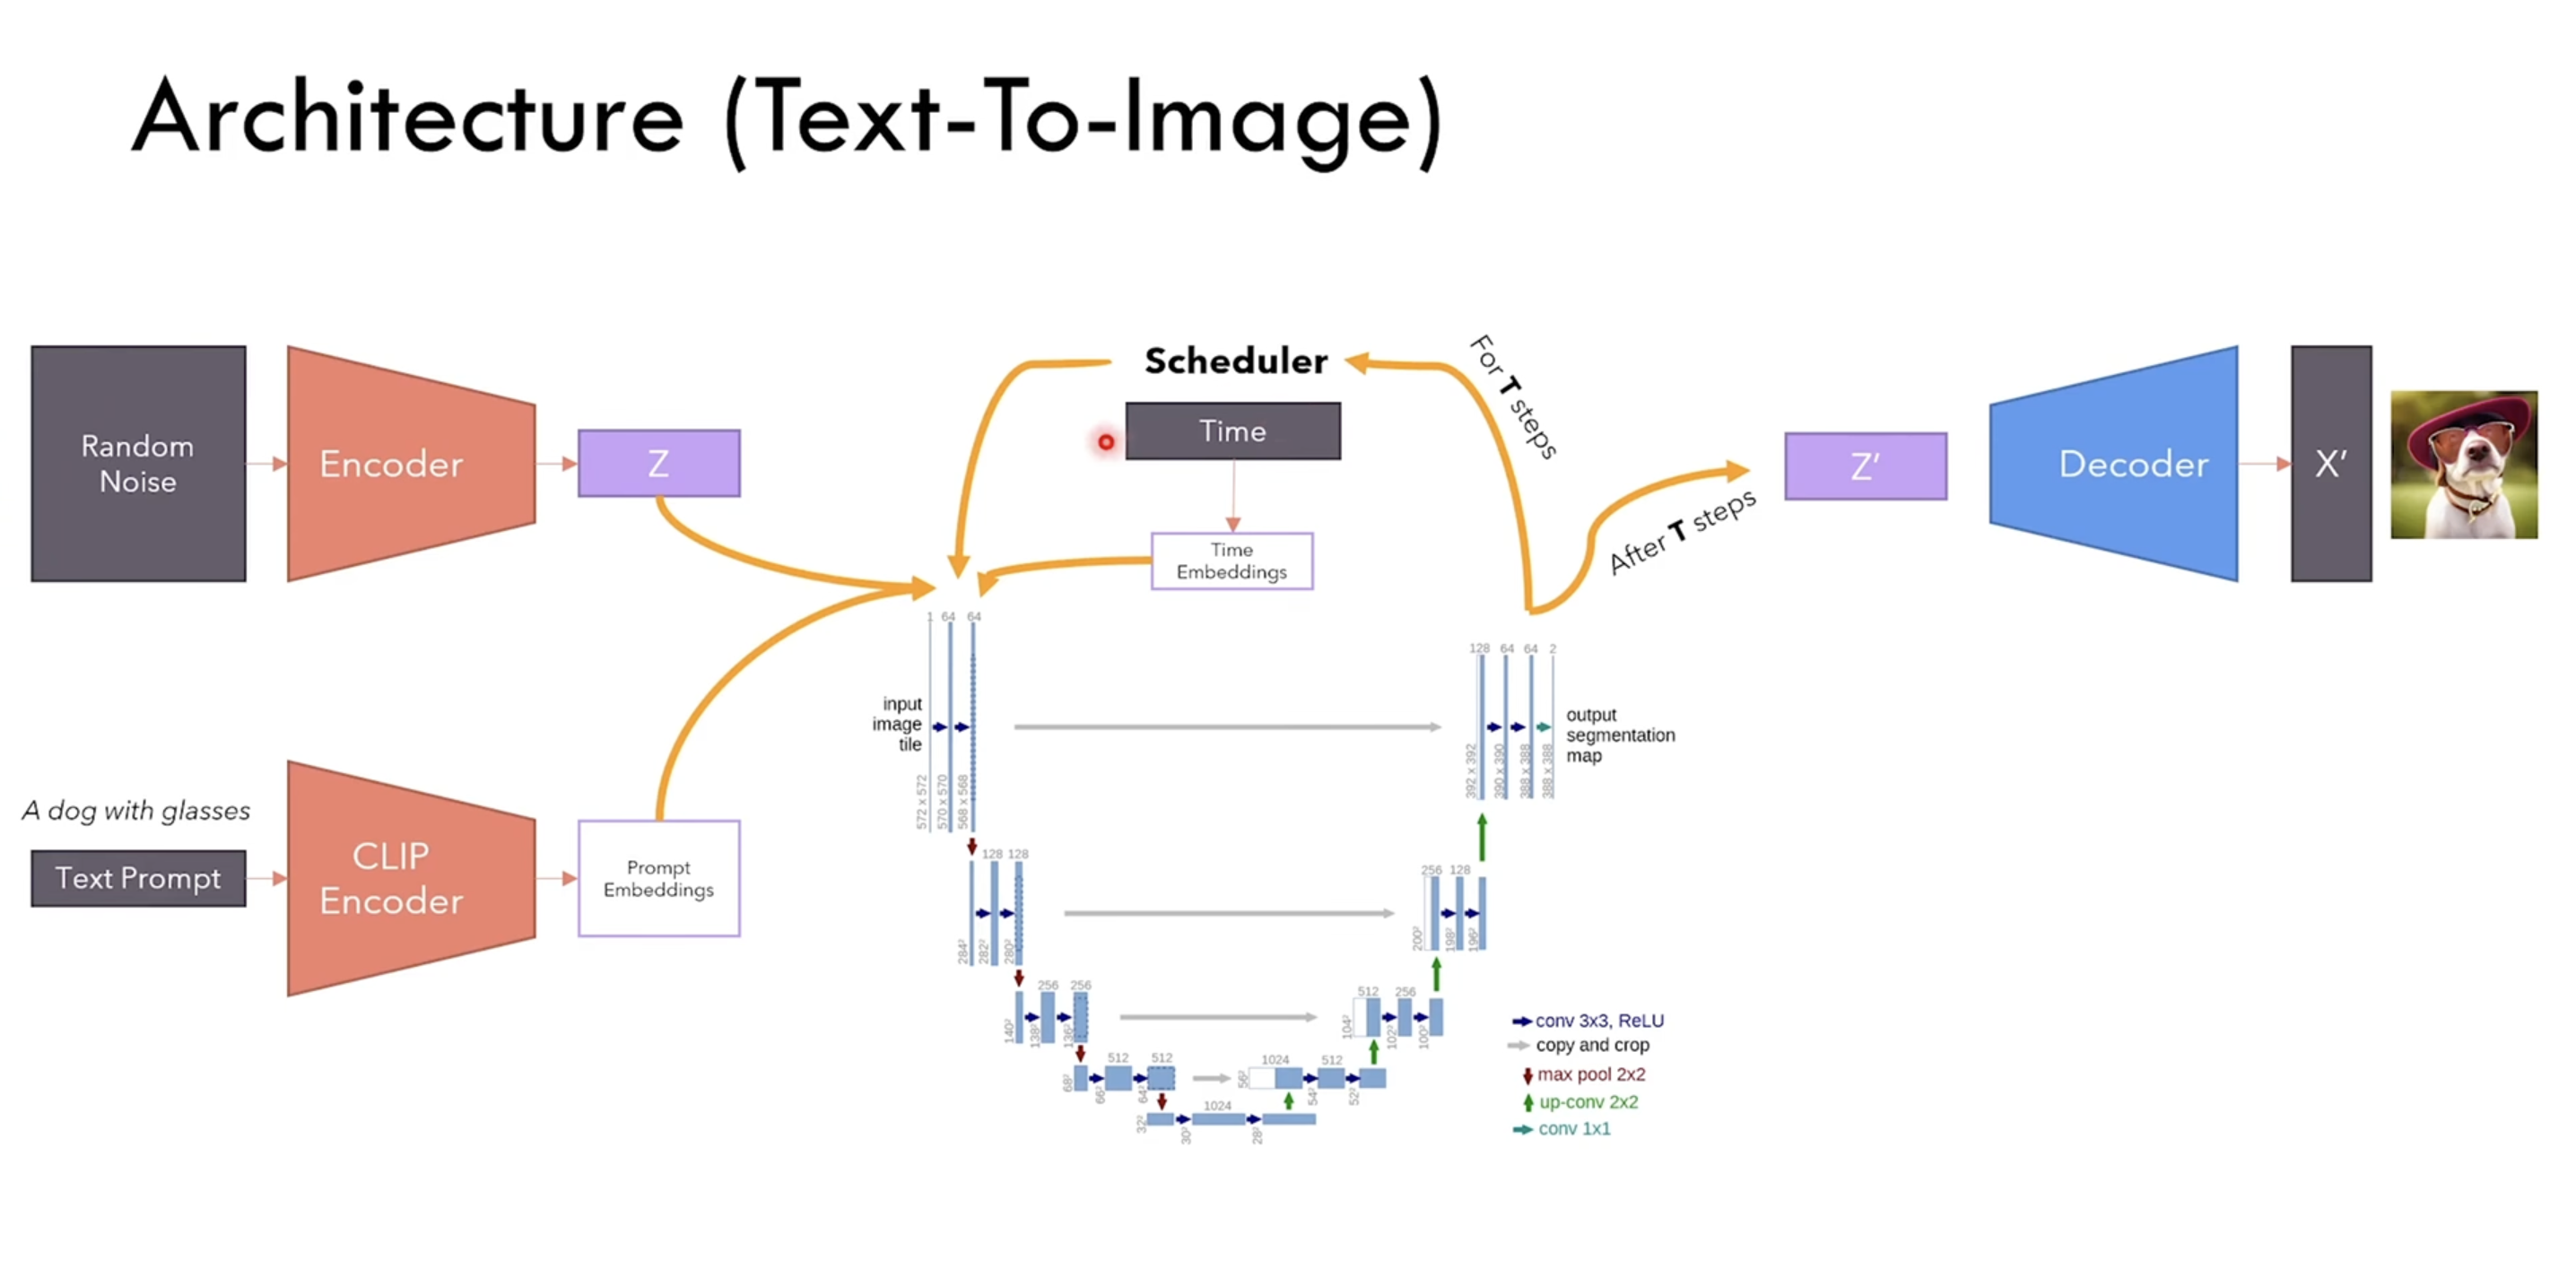
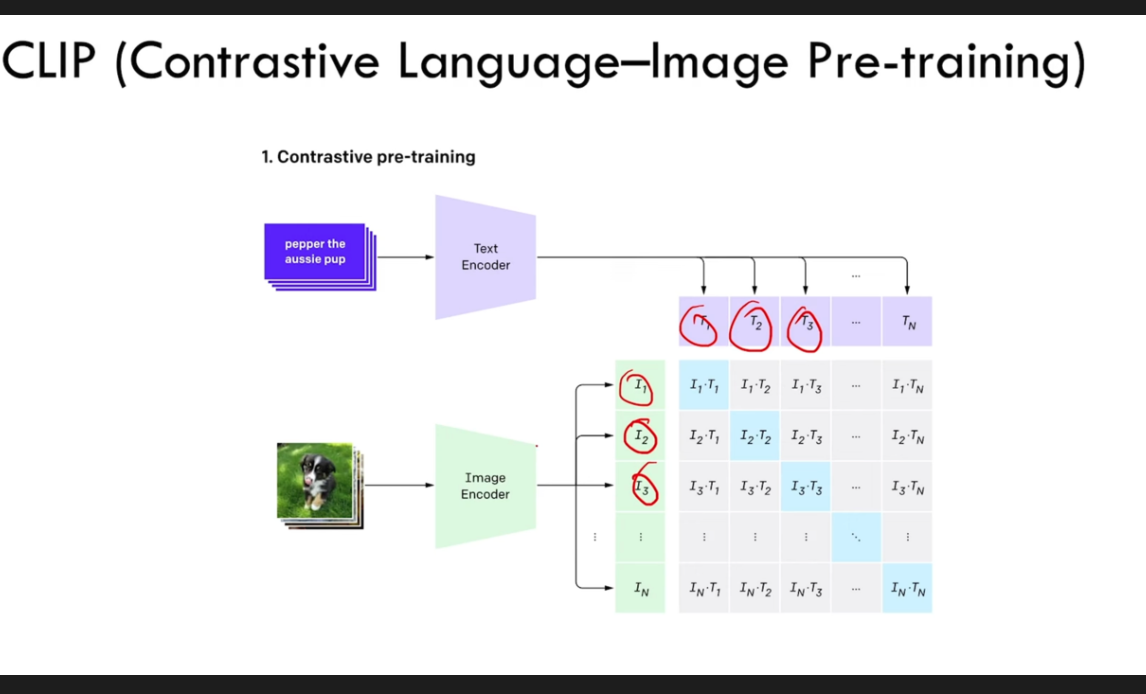
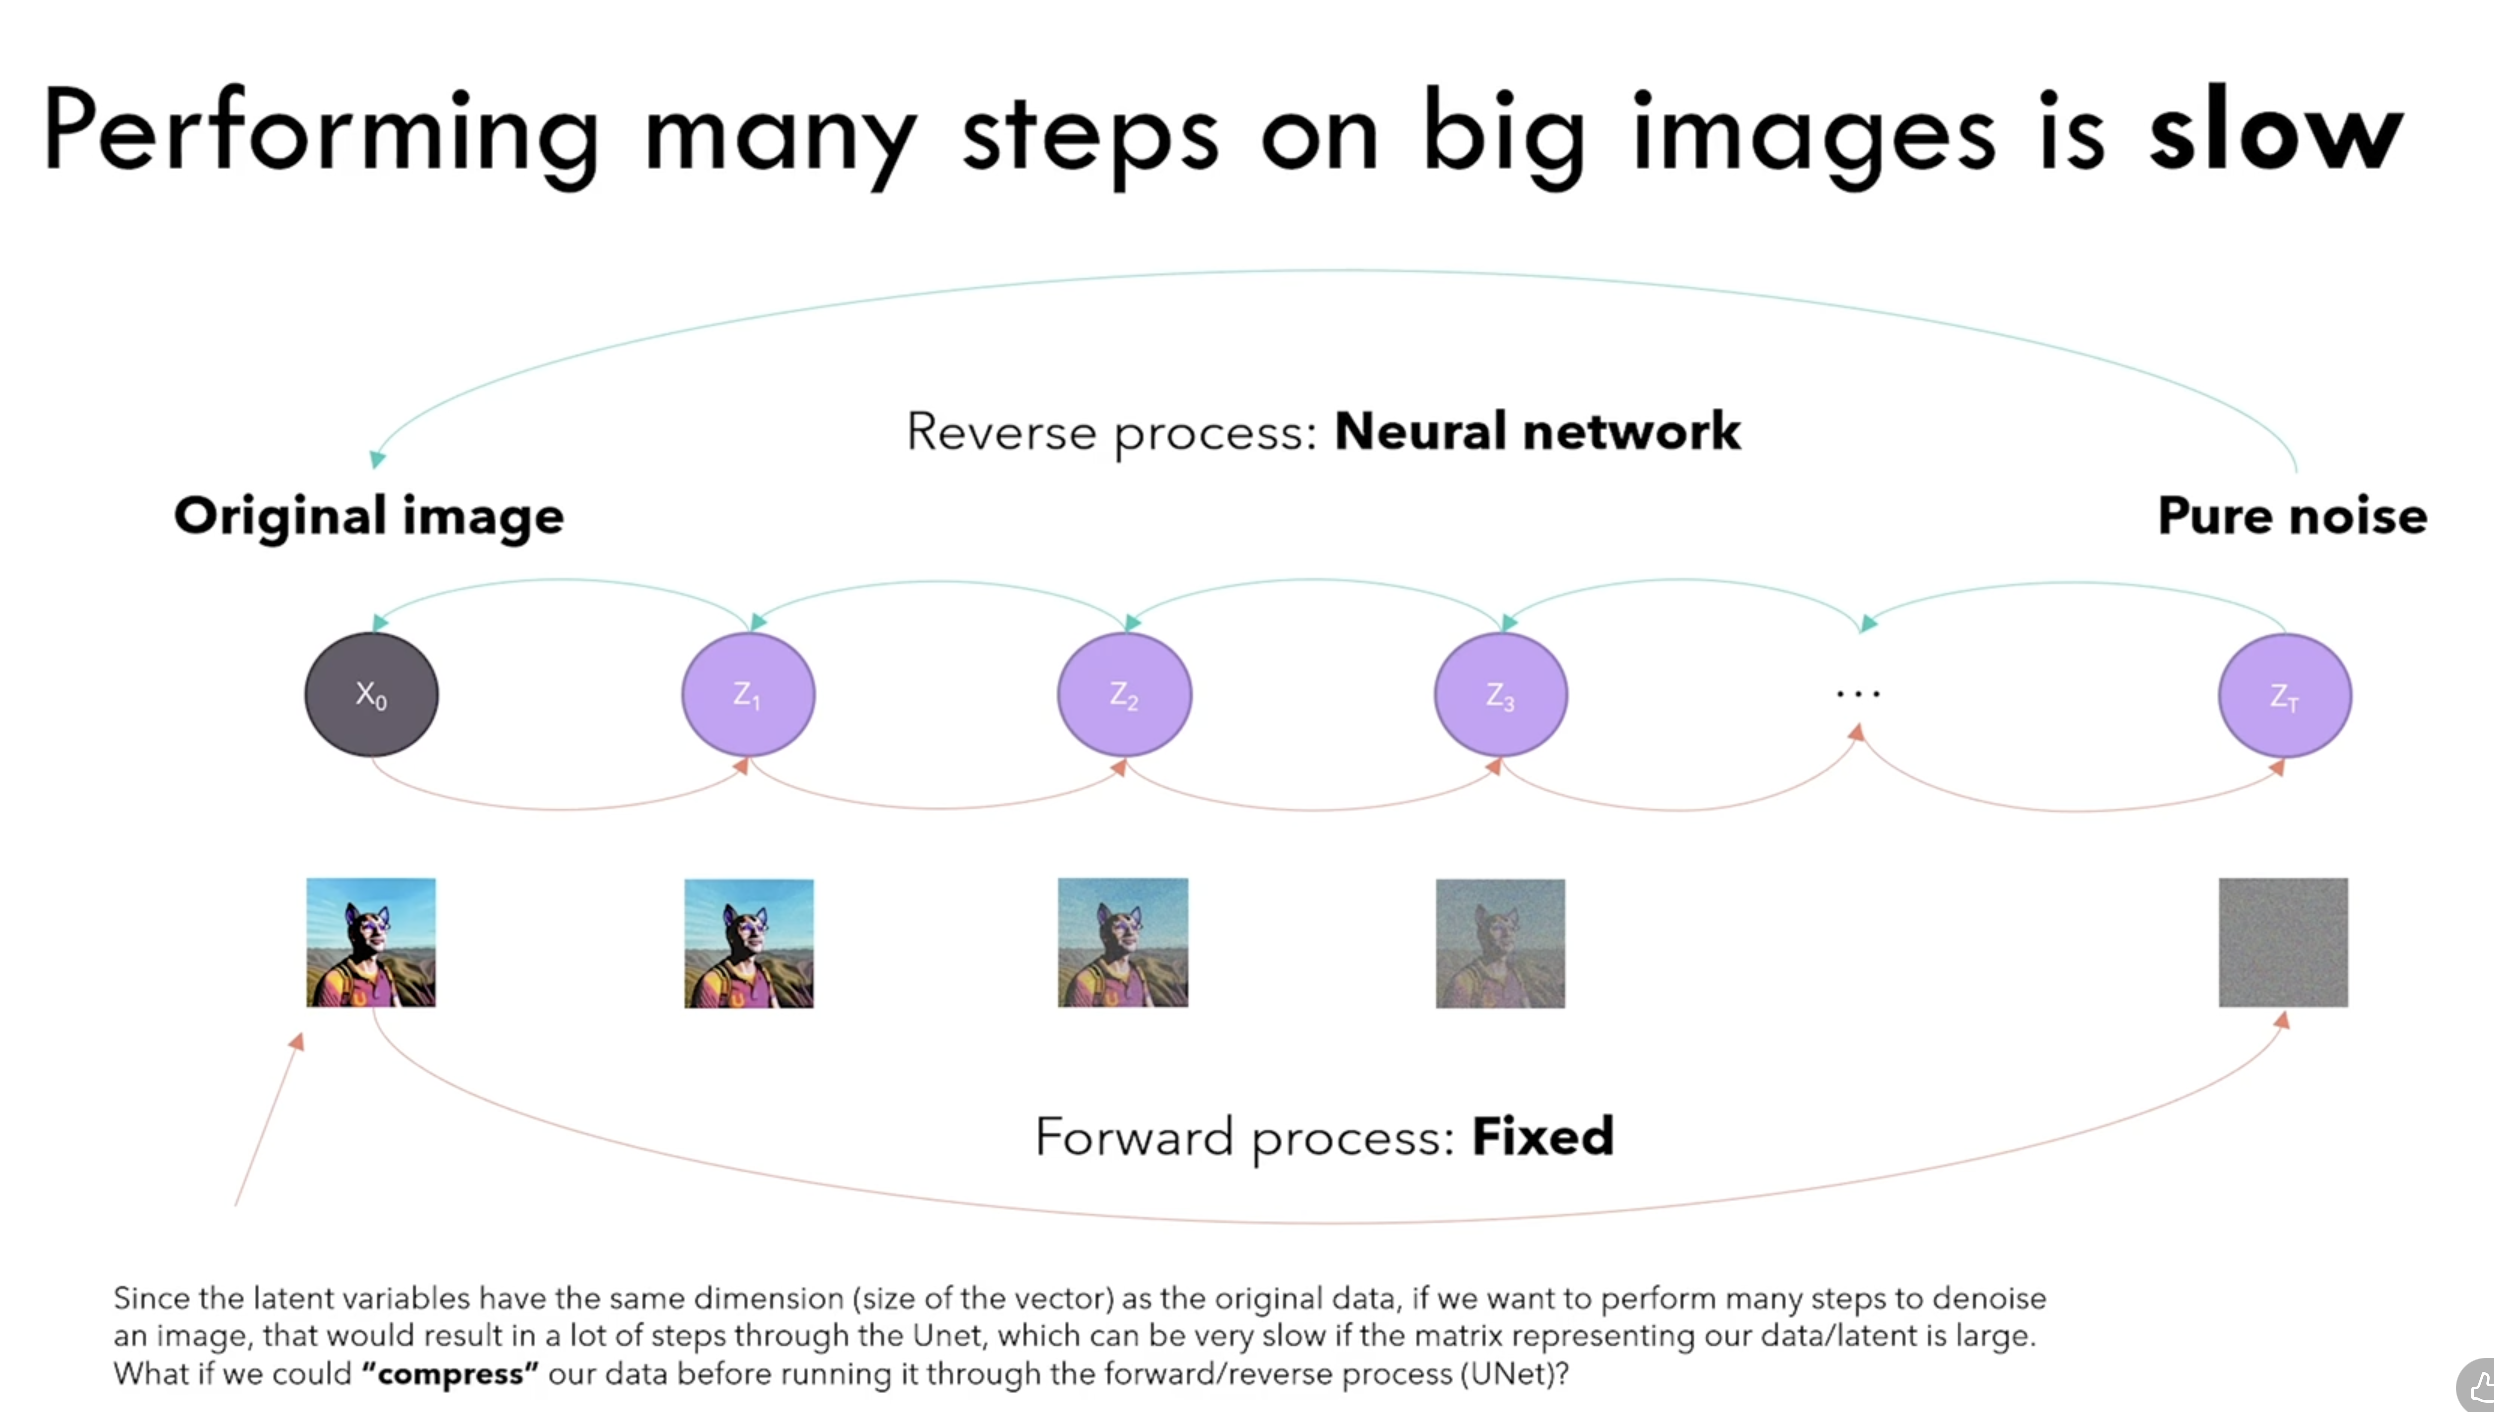



# first we will start with encoder (variational auto encoder)
- why vae --> processing images in u net could be very expensive hence instead of the image itself we use latent represenation of the image


In [ ]:
class VAE_Encoder(nn.Sequential):

    def __init__(self):

        super().__init__(

            nn.Conv2d(3, 128 , kernel_size=3 , padding = 1),               # batch_size , channel , height , width -> (batch_size , 128  , height , width) 
            Vae_ResidualBlock(128, 128 ),   #(batch_size, 128 , height , width) --> (batch_size , 128 , height , width)
            Vae_ResidualBlock(128, 128),    #(batch_size, 128 , height , width) --> (batch_size , 128 , height , width)

            nn.Conv2d(128, 128 , kernel_size=3 , stride = 2, padding = 0),  # (batch_size , 128 , height , width) -> (batch_size , 128 , height/2 , width/2)
            Vae_ResidualBlock(128, 256 ),  # (batch_size , 128 , height/2 , width/2) -> (batch_size , 256 , height/2 , width/2)
            Vae_ResidualBlock(256, 256 ),  # (batch_size , 256 , height/2 , width/2) -> (batch_size , 256 , height/2 , width/2)

            nn.Conv2d(256, 256 , kernel_size=3 , stride = 2, padding = 0),  # (batch_size , 256 , height/2 , width/2) -> (batch_size , 256 , height/4 , width/4)
            Vae_ResidualBlock(256, 512 ),  # (batch_size , 256 , height/4 , width/4) -> (batch_size , 512 , height/4 , width/4)
            Vae_ResidualBlock(512, 512 ),  # (batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/4 , width/4)

            nn.Conv2d(512, 512, kernel_size=3 , stride = 2, padding = 0),  # (batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/8 , width/8)
            Vae_ResidualBlock(512, 512 ),   #(batch_size , 512 , height/8 , width/8) -> (batch_size , 512 , height/8 , width/8)
            Vae_ResidualBlock(512, 512 ),   #(batch_size , 512 , height/8 , width/8) -> (batch_size , 512 , height/8 , width/8)

            Vae_ResidualBlock(512, 512 ),   #(batch_size , 512 , height/8 , width/8) -> (batch_size , 512 , height/8 , width/8)
            Vae_AttentionBlock(512),        #(batch_size , 512 , height/8 , width/8) -> (batch_size , 512 , height/8 , width/8) 
            Vae_ResidualBlock(512, 512),     #(batch_size , 512 , height/8 , width/8) -> (batch_size , 512 , height/8 , width/8)

            nn.GroupNorm(32, 512),         

            nn.SiLU(), 

            nn.Conv2d(512 , 8 , kernel_size = 3 , padding = 1), #  (batch_size , 512 , height/8 , width/8) -> (batch_size , 8 , height/8 , width/8)

            nn.Conv2d(8 , 8 , kernel_size = 1 , padding = 0),   # (batch_size , 8 , height/8 , width/8) -> (batch_size , 8 , height/8 , width/8)

        )

    def forward(self, x: torch.Tensor , noise: torch.Tensor):   # data(x), noise = (batchsize , channel , height , width)

        for module in self:
            if getattr(module , "stride", None ) == (2,2):
                x = F.pad(x , (0,1,0,1)) 
            x = module(x)

        log_variance = torch.clamp(log_variance , -30 , 20)  #clamping all the values between -30 and 20 for stability(all values less than -30 are set to -30 and all values greater than 20 are set to 20)
        mean , log_variance = torch.chunk(x , 2 , dim=1)    #(batch_size , 8 , height/8 , width/8) --> 2*  (batch_size , 4 , height/8 , width/8)
        variance = log_variance.exp()
        stdev= variance.sqrt()
        
        x = mean + stdev * noise
        x *= 0.8214     #scaling factor for stability(no idea where this number came from)


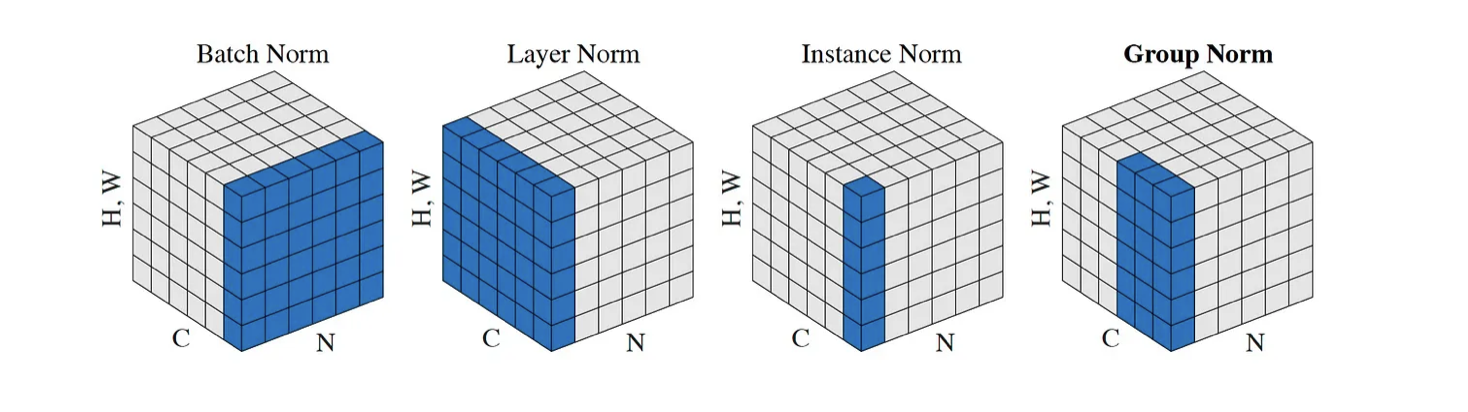
- data(x) = (batchsize , channel , height , width)
- noise = (batchsize , channel , height , width)
- kernel 3 with padding 1 keep shte same resolution
- kernal 1 with padding 0 can be seen as channel mixing information
- torch.chunk --> divides the dimension(dim=1) so that the channel is now divided into two parts 
- why group normalization --> 1. independent of batch size_ since in diffusion modle which are highly memory intensive we can afford to have large 
batch size 2. for smaller batches it outperform es the bn , however for larger batches , bn is better (need to know the technicalitites)
- why do we only use right and bottom padding --> one could use left and top won't make a difference 
- why padding --> for odd number of pixels aplying stride of 2 by 2 either stripes off the last row or column hence we pad the right and bottom with 1 pixel each, while in the case of even padding won't make a differnce becasue the last row or column will be left out
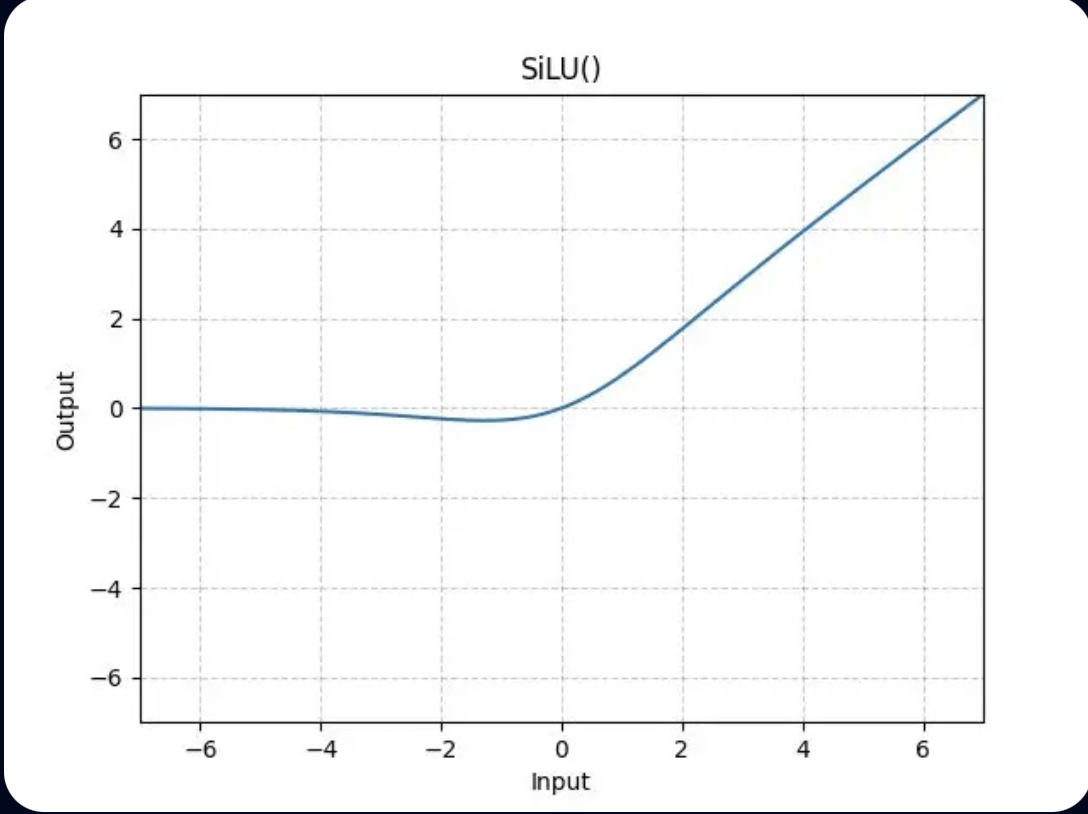
- why silu () --> large diffusion models like smopoth flow of gradient, and unlike relu, it has a small benidning curev at the bottom which facilitieistaes gradient flow, however one could argue why silu(not any other activation(in this large pool of activation), so the choice of the activation  functions are mostly empirical, hecne we can't prove why this particular activation works better than another, but we can argue the from the empirical results that this indeed work better in pratice)
- why clamp when we can normalie 
- vae is not compressed form of image , it is the distribution of the image in the latent space, and now we use that distribution to take sampples and recoinstruct the image
- log_varince --> fo rnumerical stability 
# coding variational autoencoder 
- 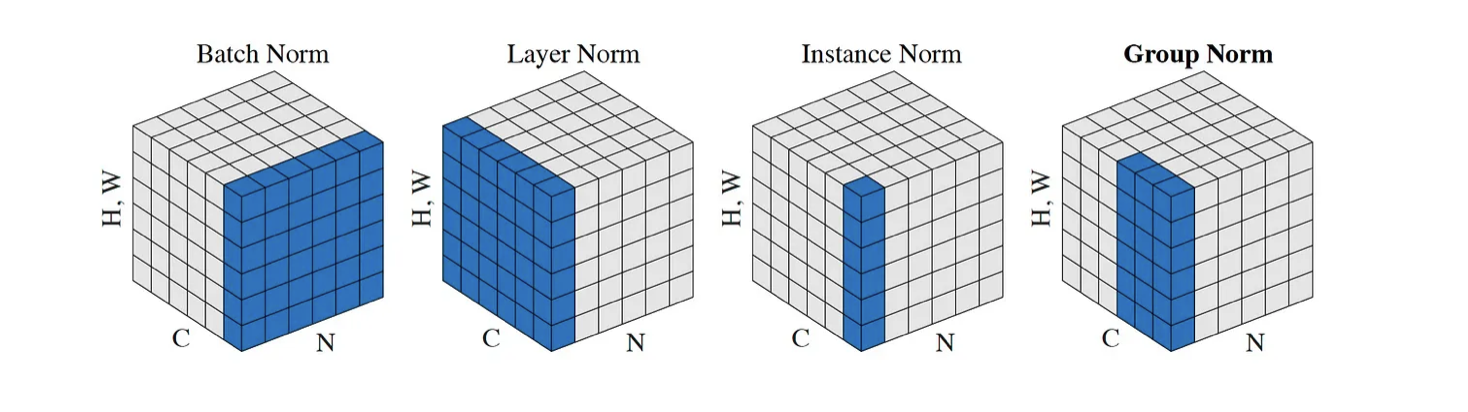


In [ ]:

x = torch.tensor([-100.0, -40.0, 0.0, 10.0, 100.0])
y = torch.clamp(x, min=-30.0, max=20.0)
y


tensor([-30., -30.,   0.,  10.,  20.])

# vae block architecture 

In [ ]:
class Vae_ResidualBlock():
    def __init__(self, in_channels , out_channels):
        super().__init__()

        self.groupnorm_1 = nn.GroupNorm(32, in_channels)
        self.conv_1 = nn.Conv2d(in_channels , out_channels, kernel_size=3 , padding=1)

        self.groupnorm_2 = nn.GroupNorm(32, out_channels)
        self.conv_2 = nn.Conv2d(out_channels, out_channels, kernel_size=3 , padding=1)

        #skip connection(smooth gradient flow)
        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else :
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
    
    def forward(self , x: torch.Tensor) -> torch.Tensor:
        
        residue = x             # residue = (batchsize , in_channels , height , width), x = (batchsize , in_channels , height , width)
        x = self.groupnorm_1(x)
        x = F.silu(x)
        x = self.conv_1(x)
        x = self.groupnorm_2(x)
        x = F.silu(x)
        x = self.conv_2(x)

        return x + self.residual_layer(residue)


- the input channel of x is taken before processig layers if the input channel is same as the output channle a(group , conv) after processing then the residual network is identuyt otherwise conv layer

In [ ]:
    
#decoder 

class VAE_Decoder(nn.Sequential):

    def __init__(self):

        super().__init__(
            nn.Conv2d(4, 4 , kernel_size=1 , padding = 0),        #(batch_size, 4 , height/8 , width/8) --> (batch_size , 4 , height/8 , width/8) , padding = 1
            nn.Conv2d(4 , 512 , kernel_size = 3 , padding = 1),     #(batch_size, 4 , height/8 , width/8) --> (batch_size , 512 , height/8 , width/8) , padding = 1


            Vae_ResidualBlock(512, 512 ),        #(batch_size, 512 , height/8 , width/8) --> (batch_size , 512 , height/8 , width/8)
            Vae_AttentionBlock(512),            #(batch_size, 512 , height/8 , width/8) --> (batch_size , 512 , height/8 , width/8)
            Vae_ResidualBlock(512, 512),        #(batch_size, 512 , height/8 , width/8) --> (batch_size , 512 , height/8 , width/8)
            Vae_ResidualBlock(512, 512 ),       #(batch_size, 512 , height/8 , width/8) --> (batch_size , 512 , height/8 , width/8)
            Vae_ResidualBlock(512, 512),       #(batch_size, 512 , height/8 , width/8) --> (batch_size , 512 , height/8 , width/8)
            Vae_ResidualBlock(512, 512 ),      #(batch_size, 512 , height/8 , width/8) --> (batch_size , 512 , height/8 , width/8)

            # upsampling by taking the value from the nearest neighbour
            nn.Upsample(scale_factor=2),        # (batch_size, 512 , height/8 , width/8) --> (batch_size , 512 , height/4 , width/4)

            nn.Conv2d(512, 512 , kernel_size=3 ,padding = 1),   # (batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/4 , width/4)
            nn.Conv2d(512, 512 , kernel_size=3 ,padding = 1),   # (batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/4 , width/4)
            Vae_ResidualBlock(512, 512 ),                   #(batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/4 , width/4)
            Vae_ResidualBlock(512, 512 ),                   #(batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/4 , width/4)
            Vae_ResidualBlock(512, 512 ),                   #(batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/4 , width/4)

            nn.Conv2d(512, 512, kernel_size=3 , stride = 2, padding = 0),   #(batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/2 , width/2)
            Vae_ResidualBlock(512, 512 ),                    #(batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/4 , width/4)
            Vae_ResidualBlock(512, 512 ),                       #(batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/4 , width/4)
            Vae_ResidualBlock(512, 512 ),            #(batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/4 , width/4)

            nn.Upsample(scale_factor=2),        #(batch_size , 512 , height/4 , width/4) -> (batch_size , 512 , height/2 , width/2)

            nn.Conv2d(512, 512, kernel_size=3 , padding = 1),   #(batch_size , 512 , height/2 , width/2) -> (batch_size , 512 , height/2 , width/2)
            Vae_ResidualBlock(512, 512 ),                    #(batch_size , 512 , height/2 , width/2) -> (batch_size , 512 , height/2 , width/2)
            Vae_ResidualBlock(512, 512 ),                       #(batch_size , 512 , height/2 , width/2) -> (batch_size , 512   , height/2 , width/2)       
            Vae_ResidualBlock(512, 256 ),       #(batch_size , 512 , height/2 , width/2) -> (batch_size , 256 , height/2 , width/2)
            Vae_ResidualBlock(256, 256 ),       #(batch_size , 256 , height/2 , width/2) -> (batch_size , 256 , height/2 , width/2)
            Vae_ResidualBlock(256, 256 ),       #(batch_size , 256 , height/2 , width/2) -> (batch_size , 256 , height/2 , width/2)

            nn.Upsample(scale_factor=2),     #(batch_size , 256 , height/2 , width/2) -> (batch_size , 256 , height , width)

            nn.Conv2d(256, 256, kernel_size=3 , padding = 1),   #(batch_size , 256 , height , width) -> (batch_size , 256 , height , width)
            Vae_ResidualBlock(256 ,128),        #(batch_size , 256 , height , width) -> (batch_size , 128 , height , width)
            Vae_ResidualBlock(128, 128 ),       #(batch_size , 128 , height , width) -> (batch_size , 128 , height , width)
            Vae_ResidualBlock(128, 128 ),       #(batch_size , 128 , height , width) -> (batch_size , 128 , height , width)

            nn.GroupNorm(32, 128),      # divide 128 features in group of 32

            nn.SiLU(),

            nn.Conv2d(128 , 3 , kernel_size=3 , padding=1)    # (batch_size , 128 , height , width) -> (batch_size , 3 , height , width)

        )

    def forward(self , x):
            
            x /= 0.18214    #dividing by the same number which was multiplied in the encoder for stability

            for module in self:
                 x= module(x)

            return x
    

# attention block 

In [ ]:
# attention block 

class Vae_AttentionBlock(nn.Module):
    
    def __init__(self , channels: int):

        super().__init__()

        self.groupnorm = nn.GroupNorm(32 , channels)
        self.attention = SelfAttention(1, channels)

    def forward(self, x: torch.Tensor):

        residue = x     #residue, x = (batchsize , channels , height , width)

        x = self.groupnorm(x)
        n , c , h , w = x.shape

        x = x.view(n , c , h*w)    # (batch_size , channel , height ,width) -> (batch_size  , channel , height * width)
        x = x.transpose(-1,-2)      # (batch_size  , channel , height * width) -> (batch_size , height * width , channel)

        x = self.attention(x)   # (batch_size , sequence/height*width , channel/embd) -> (batch_size , height * width , channel)

        x = x.transpose(-1, -2)     # (batch_size , height * width , channel) -> (batch_size  , channel , height * width)
        x = x.view(n,c,h,w)     # (batch_size  , channel , height * width) -> (batch_size , channel , height ,width)

        x += residue    #(batchsize , channels , height , width)

        return x
        




In [ ]:
#self attention
class SelfAttention(nn.Module):

    def __init__( self , n_heads:int, d_embd: int, in_proj_bias=True , out_proj=True):

        super().__init__()

        self.in_proj = nn.Linear( d_embd, 3 * d_embd , bias= in_proj_bias)  
        self.out_proj = nn.Linear(d_embd, d_embd, bias=out_proj)
        self.n_heads = n_heads
        self.d_head = d_embd // n_heads

    def forward(self, x:torch.Tensor , casual_mask= True):

        input_shape = x.shape   # (batch_size , sequence_len/height*width , d_embd/channels)
        batch_size , sequence_len , self.d_embd = input_shape   

        intermediate_shape = (batch_size, sequence_len, self.n_heads , self.d_head)

        q,k,v = self.in_proj(x).chunk( 3, dim=-1)       #(batch_size , sequence_len , d_embd) -> (batch_size , sequence_len , 3* d_embd) ->(chunk) -> 3 * (batch_size , sequence_len , d_embd)

        q = q.view(intermediate_shape).transpose(1,2)   # (batch_size , sequence_len , d_embd) -> (batch_size , sequence_len , n_heads , d_head) -> (batch_size , n_heads , sequence_len , d_head)
        k = k.view(intermediate_shape).transpose(1,2)   # (batch_size , sequence_len , d_embd) -> (batch_size , sequence_len , n_heads , d_head) -> (batch_size , n_heads , sequence_len , d_head)
        v = v.view(intermediate_shape).transpose(1,2)   # (batch_size , sequence_len , d_embd) -> (batch_size , sequence_len , n_heads , d_head) -> (batch_size , n_heads , sequence_len , d_head)

        wei = q @ k.T   #wei(batch_size , n_heads , sequence_len , sequence_len) = (batch_size , n_heads , sequence_len , d_head) @ (batch_size , n_heads , d_head , sequence_len) 
        if casual_mask:     # weather we want masked attention or not
            mask = torch.ones_like(wei , dtype=torch.bool).tril(1)
            wei.masked_fill_(mask, -torch.inf)

        wei = wei/math.sqrt(self.d_head)
        wei = F.softmax(wei, dim = -1)

        output = wei @ v        #output  -> (batch_size , n_heads , sequence_len , d_head)
        output = output.transpose(1,2)  # (batch_size , sequence_len , n_heads , d_head)
        output = output.reshape(input_shape)    # (batch_size , sequence_len , d_embd)
        output = self.out_proj(output)      # (batch_size , sequence_len , d_embd)

        return output


- if we think carefully attention is calculated between pixel corresponding across the differernt channels, so the idea is to nmaek the model learning the pattern between these pixels in the feature space, in feature space different kernal are applied across lets's say a patch of 3* 3 we got c channels , but the corresponding points in that c channels are all representative of the local patch information(of differernt kind) so the modle is trying to learn the importnat between these picel represneted across channel(could be seen as high dimentional vector) using attention mechnainsm which was quite interesting for me to visualize

In [ ]:
class CrossAttention(nn.Module):

    def __init__(self, n_heads, d_embd , d_cross , in_proj_bias = True , out_proj_bias= True): 

        super().__init__()

        self.q_proj = nn.Linear(d_embd , d_embd, bias = in_proj_bias)
        self.k_proj = nn.Linear(d_cross , d_embd, bias = in_proj_bias)
        self.v_proj = nn.Linear(d_cross , d_embd, bias = in_proj_bias)

        self.out_proj = nn.Linear(d_embd, d_embd , bias = out_proj_bias)

        self.n_heads = n_heads
        self.d_head = d_embd//n_heads

    def forward(self,x,y):

        # x(latent) --> batch_size , seq_len_q, dim_q
        # y(context) --> batch_size , seq_len_kv , dim_kv = (batchsize , 77, 768)
        input_shape = x .shape
        batch_size , sequence_length , d_embd = input_shape

        #dividing the embedding dim into n_heads and d_head
        intermin_shape =(batch_size , -1 ,self.n_heads , self.d_head)   #(batch_size , seq_len , n_heads , d_head)

        q = self.q_proj(x)      #(batch_size , seq_len_q , d_embd)
        k = self.k_proj(y)      #(batch_size , seq_len_kv , d_embd)
        v = self.v_proj(y)      #(batch_size , seq_len_kv , d_embd)

        q = q.view(intermin_shape).transpose(1,2)   #(batch_size , seq_len_q , d_embd) -> (batch_size , seq_len_q , n_heads , d_head) -> (batch_size , n_heads , seq_len_q , d_head)
        k = k.view(intermin_shape).transpose(1,2)   #(batch_size , seq_len_kv , d_embd) -> (batch_size , seq_len_kv , n_heads , d_head) -> (batch_size , n_heads , seq_len_kv , d_head)
        v = v.view(intermin_shape).transpose(1,2)   #(batch_size , seq_len_kv , d_embd) -> (batch_size , seq_len_kv , n_heads , d_head) -> (batch_size , n_heads , seq_len_kv , d_head)

        wei = q @ k.t(-1,-2)    #wei -> (batch_size , n_heads , seq_len_q , seq_len_kv) = (batch_size , n_heads , seq_len_q , d_head) @ (batch_size , n_heads , d_head , seq_len_kv)
        wei /= math.sqrt(self.d_head)
        wei = F.softmax(wei, dim=1)

        output = wei * v    # output -> (batch_size , n_heads , seq_len_q , d_head)
        output= output.t(1,2).contiguous()      #output(batch_size , seq_len_q , n_heads , d_head)
        output = output.view(input_shape)       #(batch_size , seq_len_q , d_embd)  , d_embd = n_heads * d_head
        output = self.out_proj(output)          # (batch_size , seq_len_q , d_embd)

        return output

- what is contiguous -> when we do trnaspose the pytoch just change the view not ht eunderlying order of the data,so the tensor becomes discontinuoys(not in the correct order, values are not stored nect to each other) (non-contiguous tenspor), and some pytorch functiuonality requires the tensors to be contiguous (like view()) hence we do that.